# Model Implementation

In this notebook it will be described the process of implementing and testing the performance of our custom models, it will follow the next setps:

- Creating the models.
- Define training parameters, optimizer, loss function and metrics.
- Load the training dataset from the TFRecords files, applying the function to obtain the desired feature.
- Models are trained.
- Performance is evaluated.


In [2]:
#import the necessary libraries
from models import simple_cnn
from models import simple_stacked_fc_nn
from models import custom_vgg
from data_utils import get_dataset_from_tfrecords
from data_utils import audio_to_spectogram
from data_utils import audio_to_melspectogram
from data_utils import audio_to_mfcc
import matplotlib.pyplot as plt

The next function was implemented to obtain the datasets for the training, validation and testing process, this function takes as input the size of the batches and a transformation function to be applied to the audio files. The transformation function can be any of the three functions we built to extract the features from the audio: audio_to_spectogram, audio_to_melspectogram or audio_to_mfcc.


In [3]:
def get_datasets(batch_size, transformation_fc):
    """get train, validate and test datasets and perform the parsed transformation function"""
    datasets = {}
    splits = ('train', 'validate', 'test')
    for split in splits:
        ds = get_dataset_from_tfrecords(batch_size=batch_size, split=split)
        ds = ds.map(transformation_fc)    #Transform audio to spectogram
        datasets[split] = ds
    return datasets['train'], datasets['validate'], datasets['test']

In [4]:
# Function to plot training history
def plot_training_history(history):
    """Plot the training history"""

    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.show()
    return None

# 1. Creating the models

# A simple fully connected NN

This is a simple fully connected 3 layers neural network that we use just to check all the input pipeline and test our functions. As shown in the following diagram,  this network is a simple fully connected network were the input with shape m x n is flattened, after we add multiple layers of fully connected nodes and at the end we add a drop out layer followed by the final dense layer with 12 nodes using softmax as activation function.


In [15]:
#define model parameters
stacked_fc_model = simple_stacked_fc_nn(width=98,
                                        heigth=98,
                                        depth=3,
                                        units_x_layer=512,
                                        classes=12)
print(stacked_fc_model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 9604)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               4917760   
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 12)                6156      
Total params: 5,449,228
Trainable params: 5,449,228
Non-trainable params: 0
____________________________________________

In [16]:
# Defining model's training parameters
stacked_fc_model.compile(optimizer='adam',
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])

# A simple CNN
This is a simple convolutional neural network and our first approach to the solution. As shown in the following diagram,  this network starts with two pairs of layers applying a 2D convolution followed by a Max Pooling layer, after this other 2D convolution is added, the output is flattened, and we add a layer of fully connected nodes, at the end we add a drop out layer followed by the final dense layer with 12 nodes using softmax as activation function.

In [37]:
#Creates a 3 conv layers model, input 98x98, 12 output nodes
cnn_3l_model = simple_cnn(98, 98, 12)
print(cnn_3l_model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 96, 96, 98)        980       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 48, 48, 98)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 46, 46, 196)       173068    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 23, 23, 196)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 21, 21, 196)       345940    
_________________________________________________________________
flatten_5 (Flatten)          (None, 86436)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 196)              

In [38]:
cnn_3l_model.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# A custom VGG16
VGG16 is a convolutional neural network architecture for image classification  proposed by K. Simonyan and A. Zisserman on the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition” [7], this architecture reaches 92.7% in the ImageNet dataset. The following image illustrates the structure of the network:  

Basically, our custom model starts with an input with shape 98x98 and not 224x224, also, the first two convolutional layers “conv1” and the three from “conv5” were excluded, and the input change from 1000 to 10 that are the number of classes of our problem. The final diagram ended as follows: 


In [4]:
custom_vgg_model = custom_vgg(dropout_rate=0.4) # The dropout rate on the final convolution layer
print(custom_vgg_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 94, 94, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 43, 43, 128)       147584    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 41, 41, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0

In [5]:
custom_vgg_model.compile(optimizer='adam',
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])

# Training the models

Models will be trained using the three features discussed on the notebook "3.Feature_Engineering", spectrograms, mel-spectrograms and the MFCCs. The performance of each model will be analized

# Training models using the spectograms as feature.

In [14]:
# get datasets / Apply the audio to spectrogram function
train_ds, validation_ds, test_ds = get_datasets(batch_size=64, 
                                                transformation_fc=audio_to_spectogram)
print(train_ds,validation_ds, test_ds, sep='\n')

<MapDataset shapes: ((64, 98, 98, 1), (64, 1)), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((64, 98, 98, 1), (64, 1)), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((64, 98, 98, 1), (64, 1)), types: (tf.float32, tf.int64)>


Training the stacked_fc_model using the spectrogram feature

spectrogram --> stacked_fc_model

In [17]:
history = stacked_fc_model.fit(train_ds, epochs=4, validation_data=validation_ds)

Epoch 1/4
1008/1008 [==============================] - 278s 276ms/step - loss: 1.3838 - accuracy: 0.5694 - val_loss: 1.1895 - val_accuracy: 0.6546
Epoch 2/4
1008/1008 [==============================] - 290s 288ms/step - loss: 0.6972 - accuracy: 0.7718 - val_loss: 1.4063 - val_accuracy: 0.6882
Epoch 3/4
1008/1008 [==============================] - 298s 296ms/step - loss: 0.5040 - accuracy: 0.8359 - val_loss: 1.4195 - val_accuracy: 0.6858
Epoch 4/4
1008/1008 [==============================] - 285s 282ms/step - loss: 0.3786 - accuracy: 0.8777 - val_loss: 1.6243 - val_accuracy: 0.6967


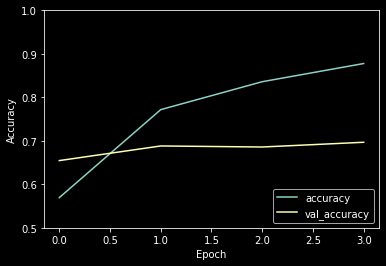

In [18]:
plot_training_history(history)

In [19]:
# Accuracy on testing set
test_loss, test_acc = stacked_fc_model.evaluate(test_ds, verbose=2)
print(f'The accuracy on the testing set is {test_acc}')

The accuracy on the testing set is 0.6817255616188049


Training the cnn_3l_model using the spectrogram feature

spectrogram --> cnn_3l_model

In [33]:
history = cnn_3l_model.fit(train_ds, epochs=4, validation_data=validation_ds)

Epoch 1/4
1008/1008 [==============================] - 283s 281ms/step - loss: 0.8039 - accuracy: 0.7476 - val_loss: 0.5702 - val_accuracy: 0.8302
Epoch 2/4
1008/1008 [==============================] - 280s 278ms/step - loss: 0.2716 - accuracy: 0.9163 - val_loss: 0.6320 - val_accuracy: 0.8325
Epoch 3/4
1008/1008 [==============================] - 281s 279ms/step - loss: 0.1556 - accuracy: 0.9557 - val_loss: 1.0335 - val_accuracy: 0.8414
Epoch 4/4
1008/1008 [==============================] - 281s 278ms/step - loss: 0.1118 - accuracy: 0.9697 - val_loss: 0.8063 - val_accuracy: 0.8366


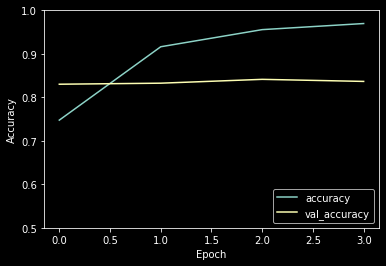

In [34]:
plot_training_history(history)

In [36]:
# Accuracy on testing set
test_loss, test_acc = cnn_3l_model.evaluate(test_ds, verbose=2)
print(f'The accuracy on the testing set is {test_acc}')

The accuracy on the testing set is 0.838994562625885


Training the custom_vgg_model using the spectrogram feature

spectrogram --> custom_vgg_model

In [49]:
history = custom_vgg_model.fit(train_ds, epochs=4, validation_data=validation_ds)

Epoch 1/4
1008/1008 [==============================] - 285s 282ms/step - loss: 1.0151 - accuracy: 0.6613 - val_loss: 0.5953 - val_accuracy: 0.8125
Epoch 2/4
1008/1008 [==============================] - 284s 282ms/step - loss: 0.3560 - accuracy: 0.8899 - val_loss: 0.4698 - val_accuracy: 0.8665
Epoch 3/4
1008/1008 [==============================] - 278s 276ms/step - loss: 0.2240 - accuracy: 0.9307 - val_loss: 0.4998 - val_accuracy: 0.8747
Epoch 4/4
1008/1008 [==============================] - 282s 280ms/step - loss: 0.1767 - accuracy: 0.9466 - val_loss: 0.5550 - val_accuracy: 0.8723


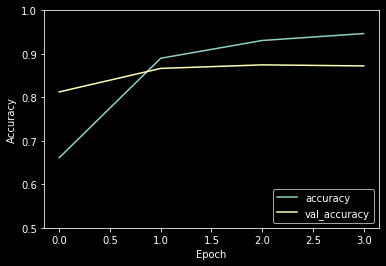

In [50]:
plot_training_history(history)

In [51]:
# Accuracy on testing set
test_loss, test_acc = custom_vgg_model.evaluate(test_ds, verbose=2)
print(f'The accuracy on the testing set is {test_acc}')

The accuracy on the testing set is 0.8739809989929199


# Training models using the mel-spectograms as feature.

In [60]:
train_ds, validation_ds, test_ds = get_datasets(batch_size=64, 
                                                transformation_fc=audio_to_melspectogram)
print(train_ds,validation_ds, test_ds, sep='\n')

<MapDataset shapes: ((64, 98, 98, 1), (64, 1)), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((64, 98, 98, 1), (64, 1)), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((64, 98, 98, 1), (64, 1)), types: (tf.float32, tf.int64)>


Training the stacked_fc_model using the mel-spectrogram feature

spectrogram --> stacked_fc_model

In [61]:
history = stacked_fc_model.fit(train_ds, epochs=4, validation_data=validation_ds)

Epoch 1/4
1008/1008 [==============================] - 276s 274ms/step - loss: 2.2101 - accuracy: 0.3776 - val_loss: 1.4161 - val_accuracy: 0.4986
Epoch 2/4
1008/1008 [==============================] - 277s 275ms/step - loss: 1.2942 - accuracy: 0.5572 - val_loss: 1.2308 - val_accuracy: 0.5808
Epoch 3/4
1008/1008 [==============================] - 274s 272ms/step - loss: 1.1198 - accuracy: 0.6184 - val_loss: 1.2503 - val_accuracy: 0.6094
Epoch 4/4
1008/1008 [==============================] - 280s 278ms/step - loss: 0.9783 - accuracy: 0.6688 - val_loss: 1.1877 - val_accuracy: 0.6270


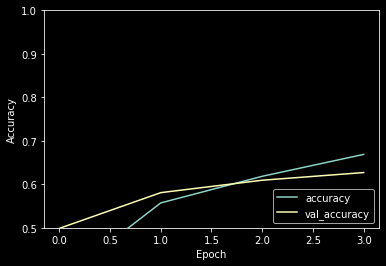

In [62]:
plot_training_history(history)

In [63]:
# Accuracy on testing set
test_loss, test_acc = stacked_fc_model.evaluate(test_ds, verbose=2)
print(f'The accuracy on the testing set is {test_acc}')

The accuracy on the testing set is 0.6226223111152649


Training the cnn_3l_model using the mel-spectrogram feature

spectrogram --> cnn_3l_model

In [64]:
history = cnn_3l_model.fit(train_ds, epochs=4, validation_data=validation_ds)

Epoch 1/4
1008/1008 [==============================] - 279s 277ms/step - loss: 0.9847 - accuracy: 0.6886 - val_loss: 0.5288 - val_accuracy: 0.8342
Epoch 2/4
1008/1008 [==============================] - 277s 275ms/step - loss: 0.3833 - accuracy: 0.8760 - val_loss: 0.5340 - val_accuracy: 0.8438
Epoch 3/4
1008/1008 [==============================] - 282s 279ms/step - loss: 0.2519 - accuracy: 0.9180 - val_loss: 0.5845 - val_accuracy: 0.8492
Epoch 4/4
1008/1008 [==============================] - 278s 276ms/step - loss: 0.1855 - accuracy: 0.9411 - val_loss: 0.6873 - val_accuracy: 0.8573


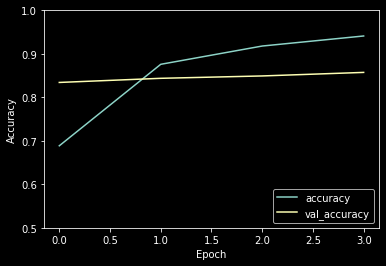

In [65]:
plot_training_history(history)

In [66]:
# Accuracy on testing set
test_loss, test_acc = cnn_3l_model.evaluate(test_ds, verbose=2)
print(f'The accuracy on the testing set is {test_acc}')

The accuracy on the testing set is 0.8447690010070801


Training the custom_vgg_model using the spectrogram feature

spectrogram --> custom_vgg_model

In [67]:
history = custom_vgg_model.fit(train_ds, epochs=4, validation_data=validation_ds)

Epoch 1/4
1008/1008 [==============================] - 289s 287ms/step - loss: 0.9523 - accuracy: 0.6763 - val_loss: 0.4635 - val_accuracy: 0.8590
Epoch 2/4
1008/1008 [==============================] - 291s 288ms/step - loss: 0.3179 - accuracy: 0.8992 - val_loss: 0.4378 - val_accuracy: 0.8679
Epoch 3/4
1008/1008 [==============================] - 292s 289ms/step - loss: 0.2164 - accuracy: 0.9321 - val_loss: 0.5261 - val_accuracy: 0.8753
Epoch 4/4
1008/1008 [==============================] - 291s 289ms/step - loss: 0.1640 - accuracy: 0.9499 - val_loss: 0.5059 - val_accuracy: 0.8781


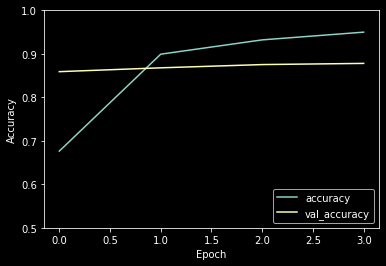

In [68]:
plot_training_history(history)

In [69]:
# Accuracy on testing set
test_loss, test_acc = custom_vgg_model.evaluate(test_ds, verbose=2)
print(f'The accuracy on the testing set is {test_acc}')

The accuracy on the testing set is 0.882472813129425


# Training models using the MFCC as feature.

In [4]:
train_ds, validation_ds, test_ds = get_datasets(batch_size=64, 
                                                transformation_fc=audio_to_mfcc)
print(train_ds,validation_ds, test_ds, sep='\n')

<MapDataset shapes: ((64, 98, 98, 1), (64, 1)), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((64, 98, 98, 1), (64, 1)), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((64, 98, 98, 1), (64, 1)), types: (tf.float32, tf.int64)>


In [7]:
history = stacked_fc_model.fit(train_ds, epochs=4, validation_data=validation_ds)

Epoch 1/4
1008/1008 [==============================] - 317s 314ms/step - loss: 2.4574 - accuracy: 0.3538 - val_loss: 1.4798 - val_accuracy: 0.4949
Epoch 2/4
1008/1008 [==============================] - 312s 310ms/step - loss: 1.3048 - accuracy: 0.5577 - val_loss: 1.2002 - val_accuracy: 0.5978
Epoch 3/4
1008/1008 [==============================] - 313s 310ms/step - loss: 1.0892 - accuracy: 0.6318 - val_loss: 1.1781 - val_accuracy: 0.6175
Epoch 4/4
1008/1008 [==============================] - 312s 309ms/step - loss: 0.9670 - accuracy: 0.6758 - val_loss: 1.1700 - val_accuracy: 0.6332


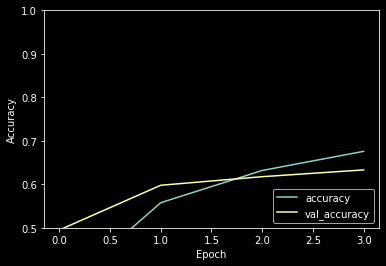

In [8]:
plot_training_history(history)

In [9]:
# Accuracy on testing set
test_loss, test_acc = stacked_fc_model.evaluate(test_ds, verbose=2)
print(f'The accuracy on the testing set is {test_acc}')

The accuracy on the testing set is 0.6338315010070801


Training the cnn_3l_model using the MFCC features

spectrogram --> cnn_3l_model

In [12]:
history = cnn_3l_model.fit(train_ds, epochs=4, validation_data=validation_ds)

Epoch 1/4
1008/1008 [==============================] - 318s 315ms/step - loss: 1.0797 - accuracy: 0.6554 - val_loss: 0.5442 - val_accuracy: 0.8257
Epoch 2/4
1008/1008 [==============================] - 312s 310ms/step - loss: 0.4329 - accuracy: 0.8593 - val_loss: 0.5193 - val_accuracy: 0.8451
Epoch 3/4
1008/1008 [==============================] - 308s 306ms/step - loss: 0.2943 - accuracy: 0.9033 - val_loss: 0.5383 - val_accuracy: 0.8387
Epoch 4/4
1008/1008 [==============================] - 309s 307ms/step - loss: 0.2250 - accuracy: 0.9274 - val_loss: 0.5937 - val_accuracy: 0.8468


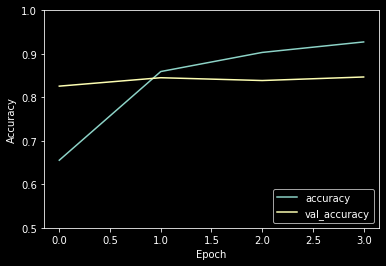

In [13]:
plot_training_history(history)

In [24]:
# Accuracy on testing set
test_loss, test_acc = cnn_3l_model.evaluate(test_ds, verbose=2)
print(f'The accuracy on the testing set is {test_acc}')

The accuracy on the testing set is 0.843410313129425


Training the custom_vgg_model using the MFCC features

spectrogram --> custom_vgg_model

In [20]:
history = custom_vgg_model.fit(train_ds, epochs=4, validation_data=validation_ds)

Epoch 1/4
1008/1008 [==============================] - 326s 324ms/step - loss: 0.8404 - accuracy: 0.7194 - val_loss: 0.4753 - val_accuracy: 0.8492
Epoch 2/4
1008/1008 [==============================] - 323s 320ms/step - loss: 0.3304 - accuracy: 0.8954 - val_loss: 0.4540 - val_accuracy: 0.8767
Epoch 3/4
1008/1008 [==============================] - 327s 325ms/step - loss: 0.2329 - accuracy: 0.9262 - val_loss: 0.5086 - val_accuracy: 0.8828
Epoch 4/4
1008/1008 [==============================] - 322s 320ms/step - loss: 0.1739 - accuracy: 0.9454 - val_loss: 0.5876 - val_accuracy: 0.8587


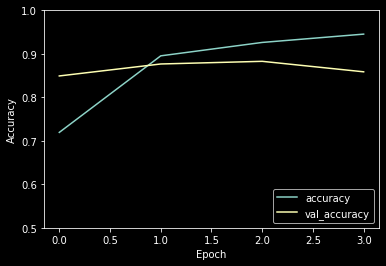

In [22]:
plot_training_history(history)

In [23]:
# Accuracy on testing set
test_loss, test_acc = custom_vgg_model.evaluate(test_ds, verbose=2)
print(f'The accuracy on the testing set is {test_acc}')

The accuracy on the testing set is 0.866847813129425


In [ ]:
#model.save_weights('data/checkpoints/custom_vgg_11')

Some thought about the results:
- The custom VGG model outperform the other models on the training and validation sets.
- Accuracy using the Mel-spectrograms tend to be slightly better than those using just the spectogram.
- Models using just the spectrogram tend to overfit more, as its accuracy on the training and validation shows bigger differences.
- Model’s performance using MFCC is lower in all cases.

From this point on we will choose the custom VGG model not only because its performance but also because it has almost half of the parameters of the 3 layers CNN model.


# Refinement
After choosing a model and the feature that gave us the best performance, we test some changes in several parameters with the aim of further improve the model’s performance. 


In [5]:
# From this point on the 
train_ds, validation_ds, test_ds = get_datasets(batch_size=64, 
                                                transformation_fc=audio_to_melspectogram)
print(train_ds,validation_ds, test_ds, sep='\n')

<MapDataset shapes: ((64, 98, 98, 1), (64, 1)), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((64, 98, 98, 1), (64, 1)), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((64, 98, 98, 1), (64, 1)), types: (tf.float32, tf.int64)>


Droping rate...


In [10]:
# Define the again the custom model with a different dropping rate
custom_vgg_model = custom_vgg(dropout_rate=0.5) # The dropout rate on the final convolution layer
custom_vgg_model.compile(optimizer='adam',
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])

In [7]:
history = custom_vgg_model.fit(train_ds, epochs=4, validation_data=validation_ds)

Epoch 1/4
1008/1008 [==============================] - 302s 300ms/step - loss: 0.8804 - accuracy: 0.7047 - val_loss: 0.4574 - val_accuracy: 0.8536
Epoch 2/4
1008/1008 [==============================] - 301s 299ms/step - loss: 0.3353 - accuracy: 0.8932 - val_loss: 0.4462 - val_accuracy: 0.8655
Epoch 3/4
1008/1008 [==============================] - 298s 296ms/step - loss: 0.2369 - accuracy: 0.9262 - val_loss: 0.4600 - val_accuracy: 0.8855
Epoch 4/4
1008/1008 [==============================] - 294s 292ms/step - loss: 0.1836 - accuracy: 0.9431 - val_loss: 0.4444 - val_accuracy: 0.8791


In [8]:
# Accuracy on testing set
test_loss, test_acc = custom_vgg_model.evaluate(test_ds, verbose=2)
print(f'The accuracy on the testing set is {test_acc}')

The accuracy on the testing set is 0.8865489363670349


More epochs ...

In [11]:
history = custom_vgg_model.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
1008/1008 [==============================] - 295s 293ms/step - loss: 0.8973 - accuracy: 0.6967 - val_loss: 0.4569 - val_accuracy: 0.8505
Epoch 2/10
1008/1008 [==============================] - 294s 292ms/step - loss: 0.3485 - accuracy: 0.8884 - val_loss: 0.4189 - val_accuracy: 0.8733
Epoch 3/10
1008/1008 [==============================] - 300s 298ms/step - loss: 0.2411 - accuracy: 0.9243 - val_loss: 0.4446 - val_accuracy: 0.8743
Epoch 4/10
1008/1008 [==============================] - 299s 296ms/step - loss: 0.1876 - accuracy: 0.9413 - val_loss: 0.4980 - val_accuracy: 0.8787
Epoch 5/10
1008/1008 [==============================] - 294s 292ms/step - loss: 0.1474 - accuracy: 0.9540 - val_loss: 0.5504 - val_accuracy: 0.8821
Epoch 6/10
1008/1008 [==============================] - 294s 291ms/step - loss: 0.1207 - accuracy: 0.9633 - val_loss: 0.6490 - val_accuracy: 0.8696
Epoch 7/10
1008/1008 [==============================] - 293s 291ms/step - loss: 0.0928 - accuracy: 0.9717 - val_

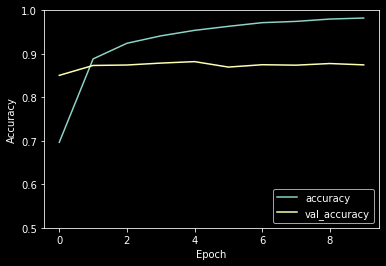

In [12]:
plot_training_history(history)

In [13]:
# Accuracy on testing set
test_loss, test_acc = custom_vgg_model.evaluate(test_ds, verbose=2)
print(f'The accuracy on the testing set is {test_acc}')

The accuracy on the testing set is 0.875


Bigger batches size ...

In [11]:
# From this point on the 
train_ds, validation_ds, test_ds = get_datasets(batch_size=256, 
                                                transformation_fc=audio_to_melspectogram)
print(train_ds,validation_ds, test_ds, sep='\n')

<MapDataset shapes: ((256, 98, 98, 1), (256, 1)), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((256, 98, 98, 1), (256, 1)), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((256, 98, 98, 1), (256, 1)), types: (tf.float32, tf.int64)>


In [12]:
history = custom_vgg_model.fit(train_ds, epochs=4, validation_data=validation_ds)

Epoch 1/4
252/252 [==============================] - 306s 1s/step - loss: 1.2580 - accuracy: 0.5640 - val_loss: 0.5513 - val_accuracy: 0.8118
Epoch 2/4
252/252 [==============================] - 302s 1s/step - loss: 0.4215 - accuracy: 0.8619 - val_loss: 0.4458 - val_accuracy: 0.8612
Epoch 3/4
252/252 [==============================] - 295s 1s/step - loss: 0.2720 - accuracy: 0.9119 - val_loss: 0.4230 - val_accuracy: 0.8764
Epoch 4/4
252/252 [==============================] - 300s 1s/step - loss: 0.2052 - accuracy: 0.9343 - val_loss: 0.4992 - val_accuracy: 0.8825


In [13]:
# Accuracy on testing set
test_loss, test_acc = custom_vgg_model.evaluate(test_ds, verbose=2)
print(f'The accuracy on the testing set is {test_acc}')

The accuracy on the testing set is 0.8806818127632141


It seems that tuning the training parameters does not have a great impact on the final model performance. It will be interesting to explore other changes such as,  further improvement on the model’s architecture or include in the data augmentation process a method to normalize the volume of the audio files.